In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.types import Command
from typing import  Annotated,Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,MessagesState,START,END
from pydantic import BaseModel, Field
llm = ChatGoogleGenerativeAI(
            model="gemini-1.5-flash",
            temperature=0,
            max_tokens=500,
            api_key='',
            max_retries=2,
            )


/home/mohamed_samy/anaconda3/envs/slash/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [285]:
members = ["Categories", "FAQ",'Unknown']
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

In [286]:
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

In [287]:
class Router(BaseModel):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal[*options]

In [288]:
messages = [
        {"role": "system", "content": system_prompt},
    ] + [{"role":'user','content':"what is the return policy ?"}]

response = llm.with_structured_output(Router).invoke(messages)

In [289]:
response.next

'FAQ'

In [4]:
class user_intent(BaseModel):
    """Identify the user intent"""
    
    faq:str=Field(
        description="if the user asked about the faq like the website policy or return days , 'yes' or 'no' "
    )
    category:str=Field(
        description="if the user asked about categories like clothes , 'yes' or 'no' "
    )
    unknown:str=Field(
        description=" if the user didn't ask about any thing or you don't know his intent or what he want, 'yes' or 'no' "
    )


In [5]:
structured_llm_grader = llm.with_structured_output(user_intent)

In [15]:
system = """You are a shop customer service that want to identify the user intent \n
    check if the user asking about faq like website policy or return days \n
    or if he ask about category like clothes  \n
    or if he said an unknown something or general question\n
    Provide a binary score 'yes' or 'no' to indicate the user intent"""
grade_prompt = ChatPromptTemplate.from_messages(
    [("system", system), ("human", "question:\n\n {question}")]
)
evaluator = grade_prompt | structured_llm_grader
result = evaluator.invoke(
    {"what is the weather today ? "}
)

In [16]:
result

user_intent(faq='no', category='no', unknown='yes')

In [255]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    categories:Annotated[list,add_messages]

members = ["category_agent", "faq_agent",'unk_agent']
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal[*options]
    
    
class MainAgent():
    def __init__(self,memory,llm):
        super(MainAgent).__init__()
        self.llm=llm
        workflow = StateGraph(AgentState)
        
        workflow.add_node("greeting",self.greeting)
        
        workflow.add_node("supervisor",self.supervisor_node)
        
        workflow.add_node("category_agent",self.clothes)
        workflow.add_node("faq_agent",self.faq)
        workflow.add_node("unk_agent",self.unknown)
        
        workflow.add_edge(START,'greeting')
        workflow.add_edge('greeting','supervisor')
        
        self.graph = workflow.compile(
            interrupt_after=['greeting','supervisor'],
            checkpointer=memory
            )
        
    def greeting(self,state:AgentState):
        return {"messages": "Hello how can i help you today ?"}
    
    def supervisor_node(self,state: AgentState) -> Command[Literal[*members, "__end__"]]:
        
        system_prompt = (
            "You are a supervisor tasked with managing a conversation between the"
            f" following workers: {members}. Given the following user request,"
            " respond with the worker to act next. Each worker will perform a"
            " task and respond with their results and status. When finished,"
            " respond with FINISH."
        )
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = self.llm.with_structured_output(Router).invoke(messages)
        goto = response.next
        if goto == "FINISH":
            goto = END

        return Command(goto=goto)
        
    def unknown(self,state:AgentState)-> Command[Literal["supervisor"]]:
        return Command(
        update={
            "messages": [
                HumanMessage(content="hello from unknown", name="unknown")
            ]
        },
        goto="supervisor",
    )
    def clothes(self,state:AgentState)-> Command[Literal["supervisor"]]:
        return Command(
        update={
            "messages": [
               HumanMessage(content="hello from clothes", name="clothes")
            ]
        },
        goto="supervisor",
    )
    def faq(self,state:AgentState)-> Command[Literal["supervisor"]]:
        return Command(
        update={
            "messages": [
               HumanMessage(content="hello from faq", name="faq")
            ]
        },
        goto="supervisor",
    )

In [391]:
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.graph.message import add_messages
from typing import  Annotated,Literal
from typing_extensions import TypedDict
from pydantic import BaseModel
from langchain.tools import tool
from langchain_core.messages import SystemMessage,HumanMessage
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langgraph.checkpoint.memory import MemorySaver

class categories(BaseModel):
    """Identify the user categories"""
    
    size:str=Field(
        description="if the user answered with his size, if not make it -1"
    )
    color:str=Field(
        description="if the user answer with his color, if not make it -1"
    )
    price:str=Field(
        description=" if the user answer about specific price, if not make it -1 "
    )
    

class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    categories: Annotated[list, add_messages]

class ClothesAgent():
    def __init__(self,memory,llm):
        self.llm=llm
        super(ClothesAgent).__init__()
        workflow = StateGraph(AgentState)
        
        workflow.add_node("ask_size",self.ask_size)
        workflow.add_node("identify_size",self.identify_size)
        
        workflow.add_edge(START,"ask_size")
        workflow.add_edge("ask_size",'identify_size')
        workflow.add_edge('identify_size',END)
        
        self.graph = workflow.compile(
            interrupt_after=['ask_size','identify_size'],
            checkpointer=memory
            )
    
    def ask_size(self,state:AgentState):
        message = state['messages'][-1]
        
        prompt = """You are a shop customer service you want to know the user size \n
                    about the specific category he want \n
                    ask him politely about his size\n
                    """
        
        grade_prompt = ChatPromptTemplate.from_messages(
        [("system", prompt), ("human", "user message:\n\n {message}")]
        )
        
        evaluator = grade_prompt | self.llm
        result = evaluator.invoke(
            message
        )
        return {"messages" : result}
    
    def identify_size(self,state:AgentState):
        structredllm = self.llm.with_structured_output(categories)
        
        message = state['messages'][-1]
        prompt = """You are a shop customer service you want to know the user size \n
                    based on the user answer \n
                    identify the user size if yes tell me the specific size if not return -1 \n
                    """
        
        grade_prompt = ChatPromptTemplate.from_messages(
        [("system", prompt), ("human", "user message:\n\n {message}")]
        )
        evaluator = grade_prompt | structredllm
        result = evaluator.invoke(
            message
        )
        
        return {'categories': result.size}

In [3]:
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.graph.message import add_messages
from typing import  Annotated,Literal
from typing_extensions import TypedDict
from pydantic import BaseModel
from langchain.tools import tool
from langchain_core.messages import SystemMessage,HumanMessage
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langgraph.checkpoint.memory import MemorySaver
import operator

class user_intent(BaseModel):
    """Identify the user intent"""
    
    faq:str=Field(
        description="if the user asked about the faq like the website policy or return days , 'yes' or 'no' "
    )
    category:str=Field(
        description="if the user asked about categories like clothes , 'yes' or 'no' "
    )
    unknown:str=Field(
        description=" if the user didn't ask about any thing or you don't know his intent or what he want, 'yes' or 'no' "
    )

class categories(BaseModel):
    """Identify the user categories"""
    
    size:str=Field(
        description="if the user answered with his size, if not make it -1"
    )
    color:str=Field(
        description="if the user answer with his color, if not make it -1"
    )
    price:str=Field(
        description=" if the user answer about specific price, if not make it -1 "
    )

memory = MemorySaver()


class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    categories: Annotated[dict[str,str],operator.__or__] = {}


class MainAgent():
    def __init__(self,memory,llm):
        self.llm = llm
        workflow = StateGraph(AgentState)
        workflow.add_node("greeting",self.greeting)
        workflow.add_node("dummy",self.dummy)
        workflow.add_node("unknown",self.unknown)
        workflow.add_node("ask_size",self.ask_size)
        workflow.add_node("identify_size",self.identify_size)
        workflow.add_node("faq",self.faq)
        workflow.add_node("ask_color",self.ask_color)
        workflow.add_node("identify_color",self.identify_color)
        
        
        workflow.add_edge(START,'greeting')
        workflow.add_edge('greeting','dummy')
        workflow.add_edge("unknown",'dummy')
        
        # workflow.add_edge("clothes","ask_size")
        workflow.add_edge("ask_size",'identify_size')
        workflow.add_edge('identify_size','ask_color')
        workflow.add_edge("ask_color",'identify_color')
        
        workflow.add_edge("faq",END)
        
        workflow.add_conditional_edges("dummy",
                                       self.user_intent,
                                       {
                                            "category": "ask_size",
                                            "faq": "faq",
                                            "unk": "unknown",
                                        })
        
        self.graph = workflow.compile(
            interrupt_after=['dummy','ask_size','ask_color','identify_color'],
            checkpointer=memory
            )
        
    def greeting(self,state:AgentState):
        return {"messages":"Hello how can i help you today ?"}
    
    def user_intent(self,state:AgentState)-> Literal["category", "faq", "unk"]:
        structredllm = self.llm.with_structured_output(user_intent)
        
        message = state["messages"][-1]
        
        prompt = """You are a shop customer service that want to identify the user intent \n
                    check if the user asking about faq like website policy or return days \n
                    or if he ask about category like clothes  \n
                    or if he said an unknown something or general question\n
                    Provide a binary score 'yes' or 'no' to indicate the user intent"""
        
        grade_prompt = ChatPromptTemplate.from_messages(
        [("system", prompt), ("human", "question:\n\n {question}")]
        )
        
        evaluator = grade_prompt | structredllm
        result = evaluator.invoke(
            message
        )
        
        if result.category =='yes':
            return 'category'
        
        elif result.faq =='yes':
            return 'faq'
        else:
            return "unk"
    
    def unknown(self,state:AgentState):
        message = state["messages"][-1]
        
        prompt = """You are a shop customer service you want to know the user intent \n
                    but the user was talking about unknown something \n
                    ask him politely what he want again\n
                    """
                    
        grade_prompt = ChatPromptTemplate.from_messages(
        [("system", prompt), ("human", "user message:\n\n {message}")]
        )
        evaluator = grade_prompt | self.llm
        result = evaluator.invoke(
            message
        )
        
        return {"messages":result}
    
    def dummy(self,state:AgentState):
        return {'messages':state['messages'][-1]}
    
    def ask_size(self,state:AgentState):
        message = state['messages'][-1]
        
        prompt = """You are a shop customer service you want to know the user size \n
                    about the specific category he want \n
                    ask him politely about his size\n
                    """
        
        grade_prompt = ChatPromptTemplate.from_messages(
        [("system", prompt), ("human", "user message:\n\n {message}")]
        )
        
        evaluator = grade_prompt | self.llm
        result = evaluator.invoke(
            message
        )
        return {"messages" : result}
    
    
    def identify_size(self,state:AgentState):
        structredllm = self.llm.with_structured_output(categories)
        
        message = state['messages'][-1]
        prompt = """You are a shop customer service you want to know the user size \n
                    based on the user answer \n
                    identify the user size if yes tell me the specific size if not return -1 \n
                    """
        
        grade_prompt = ChatPromptTemplate.from_messages(
        [("system", prompt), ("human", "user message:\n\n {message}")]
        )
        evaluator = grade_prompt | structredllm
        result = evaluator.invoke(
            message
        )
        
        return {"categories":{'size':result.size}}
    
    def ask_color(self,state:AgentState):
        message = state['messages'][-2]
        
        prompt = """You are a shop customer service you want to know the user color \n
                    about the specific category he want \n
                    ask him politely about his color\n
                    """
        
        grade_prompt = ChatPromptTemplate.from_messages(
        [("system", prompt), ("human", "user message:\n\n {message}")]
        )
        
        evaluator = grade_prompt | self.llm
        result = evaluator.invoke(
            message
        )
        return {"messages" : result}
    
    def identify_color(self,state:AgentState):
        structredllm = self.llm.with_structured_output(categories)
        
        message = state['messages'][-1]
        prompt = """You are a shop customer service you want to know the user color \n
                    based on the user answer \n
                    identify the user color if yes tell me the specific color if not return -1 \n
                    """
        
        grade_prompt = ChatPromptTemplate.from_messages(
        [("system", prompt), ("human", "user message:\n\n {message}")]
        )
        evaluator = grade_prompt | structredllm
        result = evaluator.invoke(
            message
        )
        
        return {"categories":{"color" : result.color}}
    
    def faq(self,state:AgentState):
        return {'messages':"hello from faq"}
        
        

In [40]:
# clothes_agent = ClothesAgent(memory=memory,llm=llm)
agent = MainAgent(memory,llm)

In [41]:
agent.graph.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'greeting': Node(id='greeting', name='greeting', data=greeting(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), 'dummy': Node(id='dummy', name='dummy', data=dummy(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata={'__interrupt': 'after'}), 'unknown': Node(id='unknown', name='unknown', data=unknown(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None), 'ask_size': Node(id='ask_size', name='ask_size', data=ask_size(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata={'__interrupt': 'after'}), 'identify_size': Node(id='identify_size', name='identify_size', data=identify_size(tags=None, recurse=True, func_a

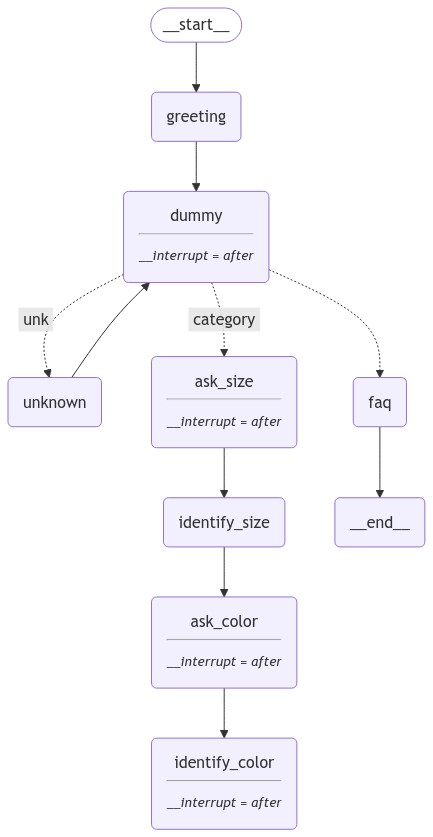

In [42]:
from IPython.display import Image,display
display(Image(agent.graph.get_graph(xray=1).draw_mermaid_png()))

In [45]:
config = {'configurable': {'thread_id' : 2}}
current_values = agent.graph.get_state(config)

In [46]:
current_values

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': 2}}, metadata=None, created_at=None, parent_config=None, tasks=())

In [19]:
messages = [HumanMessage(content="Hello")]
result = agent.graph.invoke({'messages': messages}, {'configurable': {'thread_id' : 1}})

In [20]:
result['messages'][-1].content

'Hello how can i help you today ?'

In [21]:
agent.graph.get_state({'configurable': {'thread_id' : 1}}).next

('unknown',)

In [22]:
current_values = agent.graph.get_state({'configurable': {'thread_id' : 1}})

In [23]:
current_values.values['messages'][-1]

HumanMessage(content='Hello how can i help you today ?', additional_kwargs={}, response_metadata={}, id='cd270ab8-620e-4482-b427-6097f6c36e17')

In [24]:
_id = current_values.values['messages'][-1].id
message = HumanMessage(content='I want to buy tshirt',id=_id)
current_values.values['messages'][-1] = message
agent.graph.update_state({'configurable': {'thread_id' : 1}} , current_values.values)

{'configurable': {'thread_id': 1,
  'checkpoint_ns': '',
  'checkpoint_id': '1efbc822-0798-6963-8009-84c147711f18'}}

In [25]:
agent.graph.get_state({'configurable': {'thread_id' : 1}})

StateSnapshot(values={'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='0d9e0b5a-a2ec-4951-a906-d05c650a79b8'), HumanMessage(content='I want to buy tshirt', additional_kwargs={}, response_metadata={}, id='af0e3556-a767-46e2-84b8-1273e862e67e'), AIMessage(content="That's great!  We have a wide selection of t-shirts. To help me find the perfect one for you, could you please tell me what size you wear?\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-0978ac4c-6be2-41d9-b31e-656f31aed33b-0', usage_metadata={'input_tokens': 92, 'output_tokens': 37, 'total_tokens': 129, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='75dbef87-e571-4191-ac31-c9f6e22553da'), HumanMessage(content='I want to buy tshirt', additional_kwargs={}, response_metadata={}, id='cd270ab8-620e-4482-

In [26]:
agent.graph.get_state({'configurable': {'thread_id' : 1}}).next

('ask_size',)

In [27]:
result = agent.graph.invoke(None, {'configurable': {'thread_id' : 1}})

In [29]:
result['messages'][-1]

AIMessage(content="That's great!  We have a wide selection of t-shirts. To help me find the perfect one for you, could you please tell me what size you wear?\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-eb420dc7-ff28-42fc-83ab-ac8fa1f0b4d2-0', usage_metadata={'input_tokens': 91, 'output_tokens': 37, 'total_tokens': 128, 'input_token_details': {'cache_read': 0}})

In [15]:
for event in agent.graph.stream(None, {'configurable': {'thread_id' : 1}}):
    for v in event.values():
        print(v)

{'messages': AIMessage(content="That's great!  We have a wide selection of t-shirts. To help me find the perfect one for you, could you please tell me what size you wear?\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-0978ac4c-6be2-41d9-b31e-656f31aed33b-0', usage_metadata={'input_tokens': 92, 'output_tokens': 37, 'total_tokens': 129, 'input_token_details': {'cache_read': 0}})}
()


In [875]:
agent.graph.get_state({'configurable': {'thread_id' : 1}}).next

('identify_size',)

In [876]:
current_values = agent.graph.get_state({'configurable': {'thread_id' : 1}})

In [877]:
_id = current_values.values['messages'][-1].id
current_values.values['messages'][-1].content = "my size is L"
agent.graph.update_state({'configurable': {'thread_id' : 1}} , current_values.values)

{'configurable': {'thread_id': 1,
  'checkpoint_ns': '',
  'checkpoint_id': '1efbbcd7-9ad0-6287-8005-82fa1f637cfe'}}

In [878]:
agent.graph.get_state({'configurable': {'thread_id' : 1}}).next

('identify_size',)

In [879]:
for event in agent.graph.stream(None, {'configurable': {'thread_id' : 1}}):
    for v in event.values():
        print(v)

{'categories': {'size': 'L'}}
{'messages': AIMessage(content="That's great! We have a wide variety of t-shirts.  To help me find the perfect one for you, could you tell me what color you're interested in?\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-883ae7cb-1bd7-4c45-92e0-9a02a98bab07-0', usage_metadata={'input_tokens': 89, 'output_tokens': 39, 'total_tokens': 128, 'input_token_details': {'cache_read': 0}})}
()


In [880]:
agent.graph.get_state({'configurable': {'thread_id' : 1}}).next

('identify_color',)

In [881]:
current_values = agent.graph.get_state({'configurable': {'thread_id' : 1}})

In [882]:
current_values.values['messages'][-1]

AIMessage(content="That's great! We have a wide variety of t-shirts.  To help me find the perfect one for you, could you tell me what color you're interested in?\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-883ae7cb-1bd7-4c45-92e0-9a02a98bab07-0', usage_metadata={'input_tokens': 89, 'output_tokens': 39, 'total_tokens': 128, 'input_token_details': {'cache_read': 0}})

In [883]:
_id = current_values.values['messages'][-1].id
current_values.values['messages'][-1].content = 'I want Red tshirts'
agent.graph.update_state({'configurable': {'thread_id' : 1}} , current_values.values)

{'configurable': {'thread_id': 1,
  'checkpoint_ns': '',
  'checkpoint_id': '1efbbcd7-ea77-684b-8008-d3fd284f2a1a'}}

In [884]:
agent.graph.get_state({'configurable': {'thread_id' : 1}}).next

('identify_color',)

In [885]:
for event in agent.graph.stream(None, {'configurable': {'thread_id' : 1}}):
    for v in event.values():
        print(v)

{'categories': {'color': 'Red'}}
()


In [886]:
current_values = agent.graph.get_state({'configurable': {'thread_id' : 1}})

In [887]:
current_values.values['categories']

{'size': 'L', 'color': 'Red'}

In [67]:
for x in agent.graph.stream({'messages': ['i want to buy tshirts']},{'configurable': {'thread_id' : 1}}):
            print(x)

{'greeting': {'messages': ['Hello how can i help you today ?']}}
{'__interrupt__': ()}


In [68]:
agent.graph.get_state({'configurable': {'thread_id' : 1}}).next

('unknown',)

In [67]:
config = agent.graph.get_state({'configurable': {'thread_id' : 1}}).values
config['configurable']={'thread_id' : 1}
config['messages']=5

In [68]:
for x in agent.graph.stream(None,config=config,stream_mode='values'):
            print(x)

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='a983105e-9ced-4a9c-8f3c-4ea77b14ffdd'), HumanMessage(content='test', additional_kwargs={}, response_metadata={}, id='c97b6b07-4497-4cf3-83e6-8f33eaa8624b')]}
{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='a983105e-9ced-4a9c-8f3c-4ea77b14ffdd'), HumanMessage(content='test', additional_kwargs={}, response_metadata={}, id='c97b6b07-4497-4cf3-83e6-8f33eaa8624b'), HumanMessage(content='Hello how can i help you today ?', additional_kwargs={}, response_metadata={}, id='2c563ab0-d32f-43eb-b257-c5578b3bd67c')]}


In [ ]:
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from typing import Annotated,Literal,TypedDict
from langchain_core.tools import tool


class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    order_confirmed:bool

In [201]:
@tool
def greet_user(username):
    """
    use this tool to greet the user
    """
    return f"Hello {username}, How can i help you ?"

In [202]:
tools = [greet_user]
tool_node = ToolNode(tools)

In [203]:
def chatbot(state:AgentState):
    message = state['messages']
    
    return {"messages":llm.invoke(message)}

In [204]:
memory = MemorySaver()

In [205]:
workflow= StateGraph(AgentState)
workflow.add_node('chatbot',chatbot)
workflow.add_node('greet',tool_node)
workflow.add_edge(START,'chatbot')
workflow.add_edge('chatbot','greet')
workflow.add_edge('greet','chatbot')
workflow.add_edge('chatbot',END)
app = workflow.compile(checkpointer=memory,interrupt_after=['greet'])

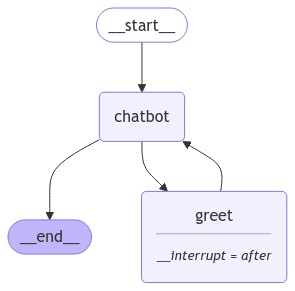

In [206]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [207]:
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = app.stream(
    {"messages": "hello my name is mohamed can you help me ?"}, config, stream_mode="values"
)
for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

hello my name is mohamed can you help me ?
================================== Ai Message ==================================

Hello Mohamed!  I'd be happy to help you.  Please tell me what you need assistance with.
================================== Ai Message ==================================

Hello Mohamed!  I'd be happy to help you.  Please tell me what you need assistance with.


In [195]:
events = app.stream(
    {"messages": "hello my name is samy can you help me ?"}, config, stream_mode="values"
)
for event in events:
    print(event['messages'])

[HumanMessage(content='hello my name is samy can you help me ?', additional_kwargs={}, response_metadata={}, id='34cb482e-96b9-4a68-8ac0-2c48fdfc3dcd'), HumanMessage(content='hello my name is samy can you help me ?', additional_kwargs={}, response_metadata={}, id='15e639e7-b693-4f78-932b-685738885a3a')]
[HumanMessage(content='hello my name is samy can you help me ?', additional_kwargs={}, response_metadata={}, id='34cb482e-96b9-4a68-8ac0-2c48fdfc3dcd'), HumanMessage(content='hello my name is samy can you help me ?', additional_kwargs={}, response_metadata={}, id='15e639e7-b693-4f78-932b-685738885a3a'), AIMessage(content="Hello Samy!  I'd love to help you.  Please tell me what you need assistance with.\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-a528dcfa-ed62-45ef-8ef3-1142cb6cb3bc-0', usage_metadata={'input_tokens': 24, 'output_tokens': 24, 'total_tokens': 48, 'input_t

In [183]:
app.get_state(config=config).next

('greet',)

In [170]:
for event in app.stream(None, config):
    for v in event.values():
        print(v)

Gemini produced an empty response. Continuing with empty message
Feedback: 


{'messages': AIMessage(content='', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}}, id='run-9ec62d5f-c2ab-4f1b-925b-d190c4e25870-0')}
{'messages': []}
()


In [65]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

In [66]:
from pydantic import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

In [67]:

# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools([RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [68]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

In [69]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

In [70]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

In [71]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

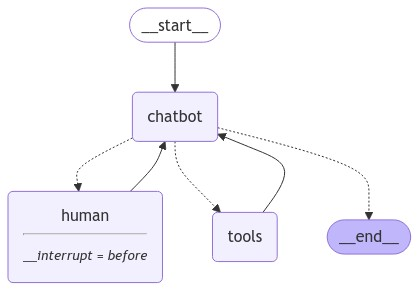

In [72]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [73]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (5909a449-aaf4-4203-9bca-a9ceddebe7a6)
 Call ID: 5909a449-aaf4-4203-9bca-a9ceddebe7a6
  Args:
    request: I need some expert guidance for building this AI agent.
